# Practical Project 

The aim of this project is to solve various forms of the portfolio optimization problem through Julia/computer software. This program template will provide hints/template code for you to focus on the optimization formulation part.

As usual, we first need to load a few packages in Julia.

In [3]:
# Load the JuMP related packages and several solvers
# ECOS - for solving SOCP problems
# Juniper & Ipopt - for solving MI-NLP problems
using JuMP, Juniper, ECOS, Ipopt
# Load the data/file processing related packages
using CSV, Glob, DataFrames, Statistics
# Load the Plot package for illustrating the solution
using Plots
# Load the custom functions for benchmarking  
include("./reusablefunc.jl");

LoadError: ArgumentError: Package Ipopt not found in current path:
- Run `import Pkg; Pkg.add("Ipopt")` to install the Ipopt package.


# Part I - Compulsory Task

#### Data Preprocessing
The first step is to load the raw data into the memory. The following codes are provided for you to help you get started. 

In [2]:
# Change "subgroup1" to other names according to the subgroup you are assigned.
path_subgroup = "./ftec_project_subgroup3/" 
files = glob( "*_train.csv", path_subgroup );
dfs = DataFrame.( CSV.File.( files ) );

In [3]:
T = 800; n = length(dfs);
stocks_retur = zeros(T,n);
for i = 1:n
    # compute the realized return R_i(t)
    stocks_retur[:,i] = (dfs[i].close-dfs[i].open) ./ dfs[i].open;
end
names_stocks = [ dfs[i].Name[1] for i in 1:n ];

## Task 4: Warm-up Exercise

For part (a) of this task, you have to plot the return of 3-4 stocks over time. An example is provided for you as follows. Use "Insert" -> "Insert Cell Below/After" if you want to keep the plots together in one place.

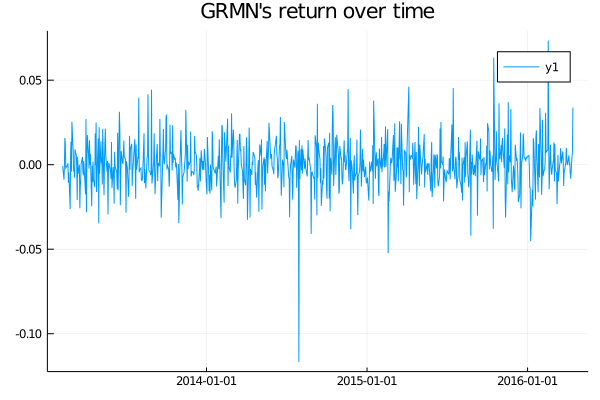

In [4]:
stock_id = 3; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].date, stocks_retur[:,stock_id] , title = dfs[stock_id].Name[1]*"'s return over time" )

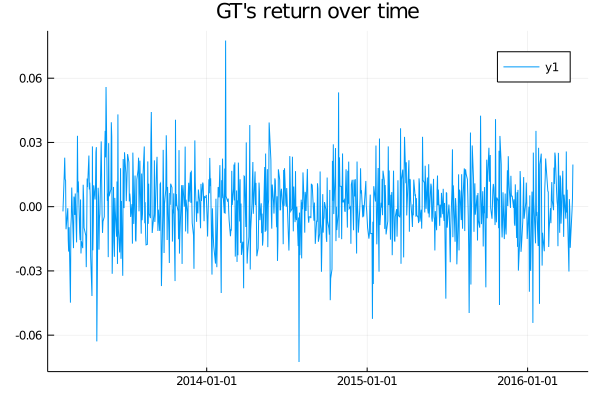

In [5]:
stock_id = 5; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].date, stocks_retur[:,stock_id] , title = dfs[stock_id].Name[1]*"'s return over time" )

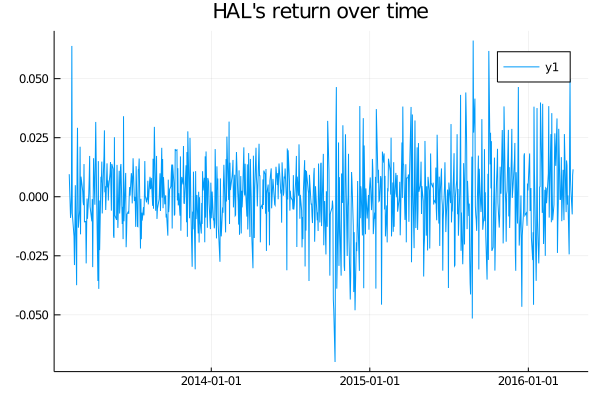

In [6]:
stock_id = 7; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].date, stocks_retur[:,stock_id] , title = dfs[stock_id].Name[1]*"'s return over time" )

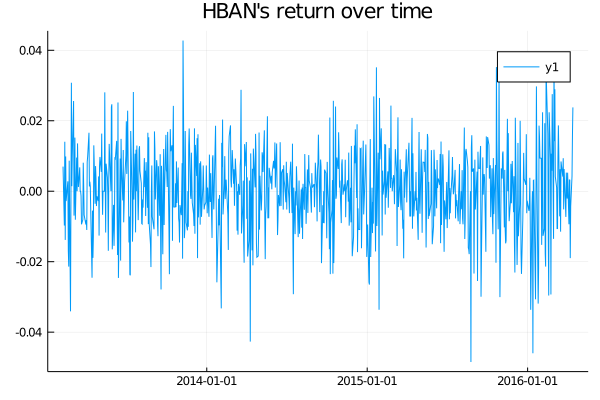

In [7]:
stock_id = 9; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].date, stocks_retur[:,stock_id] , title = dfs[stock_id].Name[1]*"'s return over time" )

For part (b) of this task, we need to estimate the expected return $\hat{r}_i$ and covariance $\hat\rho_{ij}$. Notice that these terms are given by (1.6) in the project specification. For your convenience, they have been calculated as follows:

In [8]:
# calculate r_i and Sigma
bar_R = [ mean( stocks_retur[:,i] ) for i in 1:length(dfs) ];
Sigma = [ mean( (stocks_retur[:,i].-bar_R[i]).*(stocks_retur[:,j].-bar_R[j]) ) for i=1:n, j=1:n ]; 


where "bar_R" is a $20$-dimensional vector containing the expected return $\hat{r}$ for the stocks; and "Sigma" is the $20 \times 20$ matrix of the covariance. 

## Task 5: Closed Form Solution to (1.1)

This task computes the optimal portfolio using the closed form solution derived in Task 1. Here are a few hints of useful syntax in computing the optimal solution:

- To compute the inverse of a square matrix, e.g., "$\texttt{Sigma}$", it can be done by 
$$\texttt{Sigma^-1}$$
- To create a (column) vector of all ones of $n$-dimensional. you may use 
$$\texttt{ones(n)}.$$ 
- In your closed form solution, you may need encounter something such as ${\bf 1}^\top {S} {b}$ for some $n \times n$ square matrix ${S}$, and $n$-dimensional vector ${b}$. The above expression can be computed in Julia as
$$\texttt{ones(n)'*S*b}$$
where $\texttt{ones(n)'}$ has denoted the transpose of the vector $\texttt{ones(n)}$. 

In [9]:
# your code here
#(a)
Rd = 1.01*sum(bar_R);
B = 20
r0 = bar_R'*Sigma^-1*bar_R
r1 = ones(20)'*Sigma^-1*bar_R
r2 = ones(20)'*Sigma^-1*ones(20)
portfolio_opt = ((Sigma^-1*((r0*B-r1*Rd)*ones(20)+(r2*Rd-r1*B)*bar_R))/(r0*r2-r1*r1)

20-element Array{Float64,1}:
  0.7335616789206114 
  0.6764581797196296 
  0.3661354362336461 
  0.3399176861071924 
 -0.5213586581091888 
  3.051123922301498  
 -0.8963798239355387 
  1.7627258069771405 
  0.7057288131381891 
  0.697086224066089  
  1.028256940772984  
  4.099776660748363  
  0.07567344751065148
  2.108627445583379  
  0.06324370737180932
  0.3129989719095664 
  0.5847188477166514 
  0.5294337471819142 
  1.184634736371718  
  3.097636229413709  

Suppose that $\texttt{portfolio_opt}$ has been created as a 20-dimensional vector of the optimal portfolio. The following helper code should plot the comparison of the portfolio for you. 

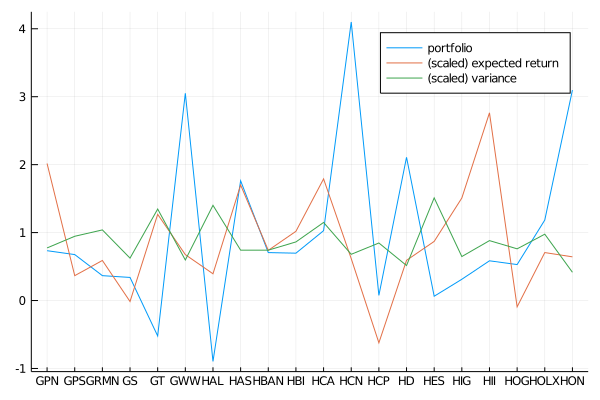

In [10]:
plot( names_stocks, portfolio_opt, labels = "portfolio", xticks = :all )
# you may adjust the scale factor "1000" to scale up/down the expected return to make it comparable with 
# the value of the portfolio (*for improved visualization only*).
plot!( names_stocks, 2000*bar_R , labels = "(scaled) expected return") 
plot!( names_stocks, 5000*[Sigma[i,i] for i in 1:n], labels = "(scaled) variance" )

## Task 6 (a): Mixed Integer Programming Solution

For this task, we shall implement the MI-NLP problem. As usual, we have to define the optimization object and specify a few parameters, as follows. The solver we are going to apply is "Juniper".

In [11]:
# the following code specifies the constants as described in the problem
M = 20; B = 20; c = 2; w = 1*ones(n); Rd = 1.01*sum( w.*bar_R ); 

# the following code setup the JuMP model with the right solver
nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
optimizer = Juniper.Optimizer
model = Model(optimizer_with_attributes(optimizer, "nl_solver"=>nl_solver, "atol"=>1e-10));



You can program the MI-NLP problem in the following cell and solve it. Here are a few hints that maybe useful.

- To be compatible with the helper codes in the latter section, please call the decision variable for the portfolio by "x_mip". 
- You may use for-loop to specify a large number of constraints. 
- To model constraint given in the form of 
$$ \sum_{i=1}^n x_i y_i \geq r $$
withe the $n$-dimensional vectors $x$, $y$. You may do so by

$$ \texttt{@constraint(model, sum( x .* y ) >= r)} $$

where $\texttt{.*}$ denotes an "element-wise" product 
- To minimize quadratic function of the form
$$ f(x) = x^\top \Sigma x $$

we first notice that 

$$ f(x) = ( \Sigma^{1/2} x )^\top ( \Sigma^{1/2} x ) $$

and the above can be modeled in JuMP by

$$ \texttt{@variable( model, y[1:n] )}$$
$$ \texttt{@constraint( model, y .= sqrt(Sigma)*x );}$$ 
$$ \texttt{@NLobjective( model, Min, sum(y[i]^2 for i in 1:n) )} $$

Notice that we shall use "$\texttt{NLObjective}$ to specify that the objective function is nonlinear.

In [12]:
# your code here
@variable(model, x_mip[1:n])
@variable(model, y_mip[1:n], Bin)
@variable(model, z_mip[1:n])
@constraint(model, z_mip .== sqrt(Sigma)*(x_mip+w))
@constraint(model, sum(x_mip.*bar_R.+w.*bar_R)  >=  Rd)
@constraint(model, sum(x_mip.+y_mip.*c) <= B)
for i = 1 : n
    @constraint(model, x_mip[i] >=-M*y_mip[i])
    @constraint(model, x_mip[i] <= M*y_mip[i])
    @constraint(model, x_mip[i] + w[i] >= 0)
end
@NLobjective( model, Min, sum(z_mip[i]^2 for i in 1:n) )
optimize!(model)

atol              : 1.0e-10
nl_solver         : MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute,Any}[RawParameter("print_level")=>0])
feasibility_pump  : false
log_levels        : Symbol[:Options, :Table, :Info]

#Variables: 60
#IntBinVar: 20
#Constraints: 82
#Linear Constraints: 82
#Quadratic Constraints: 0
#NonLinear Constraints: 0
Obj Sense: Min


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Start values are not feasible.
Status of relaxation: LOCALLY_SOLVED
Time for relaxation: 27.086999893188477
Relaxation Obj: 0.0052916543150817955

 ONodes   CLevel          Incumbent                   

## Task 6(b): SOCP Solution

For this task, we shall implement the SOCP program formulated in Task 3. As usual, we have to define the optimization object and specify a few parameters, as follows. The solver we are going to apply is "ECOS".

In [13]:
# specify the problem parameters
M = 20; B = 20; a = 2; w = ones(n); Rd = 1.01*sum( w.*bar_R ); 
# specify the JuMP model with ECOS as the optimizer
m_socp = Model( ECOS.Optimizer );

You may program the SOCP problem into JuMP as follows. Again, for convenience, you may name the decision variable of the portfolio as "x_socp". 

Further, wou may find that some constraints are similar to the MI-NLP from the previous task. However, when you "copy-and-paste" those code, don't forget to change the model name and the variable name. Here are some hints on modeling the second order cone constraints:

- To model a SOC constraint given in the form

$$ \| Ax + d \| \leq c^\top x + d, $$

you can use

$$ \texttt{ @constraint( m_socp, [c'*x + d; A*x + d] in SecondOrderCone() ) } $$

Essentially, "$\texttt{[c'*x + d; A*x + d]}$" defines a vector whose first element describes the RHS of the SOC constraint, the the remaining elements describe the vector found inside the norm of the SOC constraint. 

In [14]:
# your code here
@variable(m_socp,x_socp[1:n])
@variable(m_socp,z_socp)
@constraint(m_socp, [z_socp; sqrt(Sigma)*(x_socp+w)] in SecondOrderCone() )
@constraint(m_socp, sum(x_socp.*bar_R+w.*bar_R)-Rd  >= 0)
@constraint(m_socp, B - sum(x_socp.+a.*x_socp.*x_socp) >= 0)
for i = 1 : n
    @constraint(m_socp, x_socp[i] + M >= 0)
    @constraint(m_socp, M-x_socp[i] >= 0)
    @constraint(m_socp, x_socp[i]+w[i] >= 0)
end
@objective(m_socp, Min, z_socp)
optimize!(m_socp)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -9.758e+02  +1e+03  5e-02  5e-01  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  +7.001e-01  -2.885e+02  +3e+02  1e-02  3e-01  1e+00  5e+00  0.7547  9e-02   1  1  1 |  0  0
 2  +6.771e-01  -1.757e+02  +2e+02  9e-03  2e-01  1e+00  3e+00  0.4581  2e-01   1  1  1 |  0  0
 3  +8.179e-01  -1.604e+02  +2e+02  8e-03  5e-02  1e+00  3e+00  0.2275  6e-01   1  2  2 |  0  0
 4  +2.387e-01  -1.083e+01  +1e+01  5e-04  9e-03  2e-01  2e-01  0.9890  6e-02   1  1  1 |  0  0
 5  +2.146e-01  -5.437e-01  +9e-01  4e-05  1e-03  1e-02  1e-02  0.9400  1e-02   1  1  1 |  0  0
 6  +1.297e-01  -4.450e-01  +7e-01  3e-05  1e-03  9e-03  1e-02  0.4500  5e-01   1  1  1 |  0  0
 7  +9.801e-02  -5.234e-02  +2e-01  7e-06  3e-04  2e-03  3e-03  0.7873  6e-02   1  1  1 |  0  0
 8  +9.744e-02  -2.540e-02  +2e-01  6e-06  2e-

## Task 6(c): Plotting the portfolios found

Given that you have programmed and executed the optimization problems correctly, the following helper code shall plot the portfolios nicely for you. 

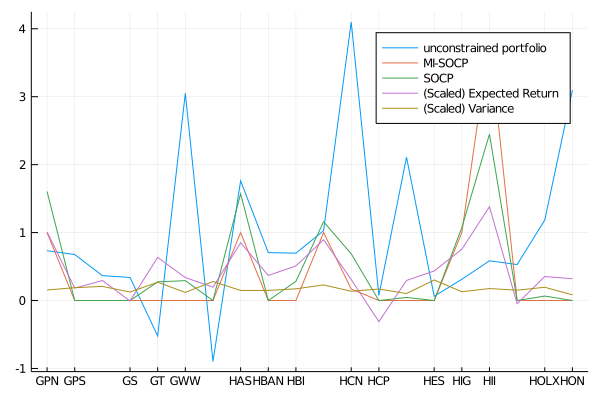

In [15]:
plot( names_stocks, portfolio_opt, labels = "unconstrained portfolio" )
plot!( names_stocks, JuMP.value.(x_mip + w), labels = "MI-SOCP")
plot!( names_stocks, JuMP.value.(x_socp + w), labels = "SOCP")
plot!( names_stocks, 1000*bar_R, labels ="(Scaled) Expected Return")
plot!( names_stocks, 1000*[Sigma[i,i] for i in 1:n], labels ="(Scaled) Variance")

## Task 7: Evaluating the Solution on Testing Set

Again, provided that you have programmed and executed the optimization problems correctly, the following helper code shall compute the Sharpe ratio and other benchmarks for you.

In [16]:
sharpe_IP = sharpe_ratio( path_subgroup, JuMP.value.(x_mip), ones(n), 2 );

Sharpe Ratio = 0.05413241598617762, Return = 0.0034187349028287875, Tx Cost = 32, Portfo Value = 7.999928404368282

In [17]:
sharpe_SOCP = sharpe_ratio( path_subgroup, JuMP.value.(x_socp), ones(n) , 2 );

Sharpe Ratio = 0.049155304786061095, Return = 0.0030793286295894414, Tx Cost = 40, Portfo Value = 9.508313830126443

In [18]:
sharpe_Opt = sharpe_ratio( path_subgroup, portfolio_opt, zeros(n), 2 );

Sharpe Ratio = 0.03802867925936308, Return = 0.004395337030779774, Tx Cost = 40, Portfo Value = 20.00000000000001

# Part II - Competitive Task

In the compulsory task, we shall implement a projected gradient method (using a constant step size) for the approximated Portfolio optimization problem. 

We shall consider the full portfolio optimization problem. For this, let us first load the stock data with the following helper code.

In [19]:
# load the full data set!
files = glob( "*_train.csv", "./ftec_project_files/");
dfs = DataFrame.( CSV.File.( files ) );
T = 800; n = length(dfs);
stocks_retur_full = zeros(T,n);
for i = 1:n
    # compute the realized return R_i(t)
    stocks_retur_full[:,i] = (dfs[i].close-dfs[i].open) ./ dfs[i].open;
end
names_stocks_full = [ dfs[i].Name[1] for i in 1:n ];
# calculate r_i and Sigma
bar_R_full = [ mean( stocks_retur_full[:,i] ) for i in 1:length(dfs) ];
Sigma_full = [ mean( (stocks_retur_full[:,i].-bar_R_full[i]).*(stocks_retur_full[:,j].-bar_R_full[j]) ) for i=1:n, j=1:n ]; 

Notice that "bar_R_full" is the expected return for all the $n=471$ stocks considered, and "Sigma_full" is the $471 \times 471$ covariance matrix for them. 

## Task 8: Implementing a Customized Solver for Approximated problem

You shall write a few helper functions to compute the objective values, the gradient vector, the projection into the box constraint, etc.. to help you with implementing the customized solver. Some useful syntax are as follows:

- For a nonlinear function $h(z)$ (such as the Huber function) on a scalar $z$. Suppose that $x$ is an $n$-dimensional vector, to create the vector 

$$ [h(x)]_i = h(x_i) $$

you may use the syntax

$$ \texttt{h.(x)} $$

where the "." after "h" broadcasts the function to every elements of the vector. 
- Note that the objective function should be dependent on "x", "w", "a", "bar_R_full", "Sigma_full", "upsilon", "zeta". 

In [20]:
# your code/functions here
function Huber_fct(x,delta,a)
        if abs(x) <= delta
            return  a*x*x/(2*delta)
        end
        if abs(x) > delta
            return a*(abs(x) - delta/2)
        end
end

Huber_fct (generic function with 1 method)

In [21]:
function fct1(x,Rd,w,bar_R_full)
    return Rd-sum((x.+w).*bar_R_full)
 end

fct1 (generic function with 1 method)

In [22]:
function fct2(x,B,delta,a)
        return sum(x)+sum(Huber_fct(x[i],delta,a) for i =1:n)-B
end

fct2 (generic function with 1 method)

In [23]:
function obj_fct(x,w,a,bar_R_full,Sigma_full,upsilon,lambda,delta)
    return (x+w)'*Sigma_full*(x+w)/2+lambda*fct1(x,Rd,w,bar_R_full)+upsilon*fct2(x,B,delta,a)
end

obj_fct (generic function with 1 method)

In [24]:
function grd_huber(x,a,delta,gh)
    for i = 1:n
        if abs(x[i]) <= delta
            gh[i] = a*x[i]/delta
        end
        if abs(x[i]) > delta
            if x[i] >= 0
                gh[i] = a
            end
            if x[i] < 0
                gh[i] =  -a
            end
        end
    end
    return gh
end

grd_huber (generic function with 1 method)

In [25]:
function grd_fct(x,w,a,bar_R_full,Sigma_full,upsilon,lambda,delta,gh)
    return Sigma_full*(x+w)-lambda*bar_R_full+upsilon*(ones(n)+grd_huber(x,a,delta,gh) )
end

grd_fct (generic function with 1 method)

In [26]:
function proj_fct(x,l,u)
    for i = 1:n
        if x[i]>u
            x[i] = u
        end
        if x[i]<l
            x[i] = l
        end
    end
    return x
end

proj_fct (generic function with 1 method)

In [27]:
function CG_fct(x,l,u,A,w,a,bar_R_full,Sigma_full,upsilon,lambda,delta,gh)
    for i = 1:n
        if A[i] >= 0
            A[i] = -1
        else
            A[i] = 20
        end
    end
        return A
end

CG_fct (generic function with 1 method)

You may program the iterative algorithm of your choice as follows. 

In [28]:
# set the parameters as specified by the problem

M = 20; w = 1*ones(n); a = 2; upsilon = 0.01; lambda = 145; delta = 1.4;

gh = zeros(n);
# initialize the algorithm
x_custom = zeros(n); 
store_obj = []
push!(store_obj, obj_fct(x_custom,w,a,bar_R_full,Sigma_full,upsilon,lambda,delta)) # replace ".." with the function you wrote for computing the objective val.

# calculate l and u - your code here (should be a simple formula)
u = M
l = -M
if w[1]<M
    l = -w[1]
end
for iteration_no = 1 : 50000 # feel free to adjust the number of iterations run here.
    # your code here
    gamma = 0.1
    x_custom = x_custom - gamma*grd_fct(x_custom,w,a,bar_R_full,Sigma_full,upsilon,lambda,delta,gh)
    x_custom = proj_fct(x_custom,l,u)
    push!(store_obj, obj_fct(x_custom,w,a,bar_R_full,Sigma_full,upsilon,lambda,delta) ) # replace ".." with the function you wrote for computing the objective val.
end


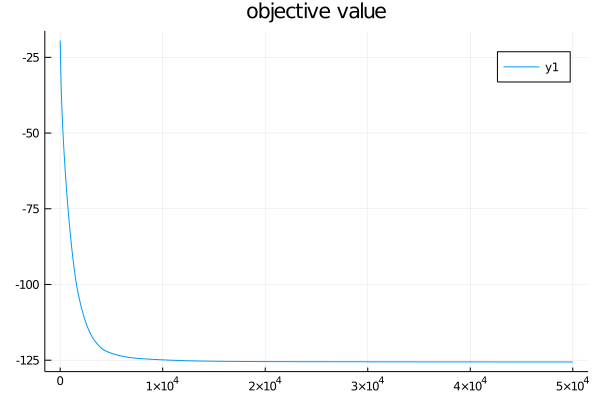

In [29]:
plot( store_obj, title = "objective value") # plot the trajectory of the optimization algorithm

Apply the post-processing step as specified in the project.

In [30]:
x_custom_pp = copy( x_custom )
x_custom_pp[ abs.(x_custom_pp) .< delta ] .= 0;

The following code computes the sharpe ratio, return, transaction cost, total cost of portfolio which will be used to calculate your score for the competitive task!

In [31]:
sharpe_PPGD = sharpe_ratio( "./ftec_project_files/", x_custom_pp, ones(n), 2 )

Sharpe Ratio = 0.09280483386727101, Return = 0.9467270268726974, Tx Cost = 188, Portfo Value = 2226.9583850586373

0.09280483386727101

It may also help to visualize the portfolio with the following code:

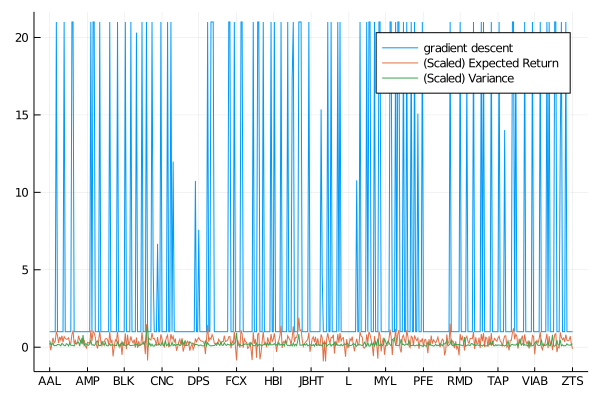

In [32]:
plot( names_stocks_full, x_custom_pp + w, labels = "gradient descent" )
plot!( names_stocks_full, 1000*bar_R_full, labels ="(Scaled) Expected Return")
plot!( names_stocks_full, 1000*[Sigma_full[i,i] for i in 1:n], labels ="(Scaled) Variance")